In [2]:
import os
import nibabel as nib
import numpy as np
from nibabel.testing import data_path
import pyopenvdb as vdb
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

from functions import parent_directory, normalize_array, create_volume, plot_examples, iso_scale_trans, view_sagittal_slice
import copy

In [3]:
#Set up output folders
parent_directory = parent_directory()

In [26]:
anat_filepath = "/workspaces/neurovolume/media/sub-01/anat/sub-01_T2w.nii.gz"
anat_image = nib.load(anat_filepath)

#anat_norm = create_volume(normalize_array(anat_image.get_fdata()))
anat_norm = create_volume(anat_image.get_fdata())

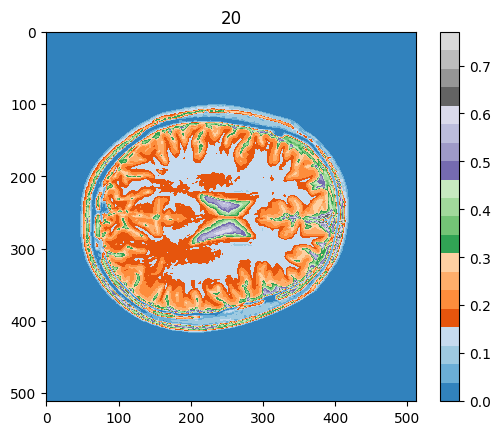

In [19]:
view_sagittal_slice(anat_norm, 20, mpl.colormaps['tab20c'])

In [20]:
print(iso_scale_trans(anat_image.affine)) #TODO this should be an object with methods

[[-0.5, 0.0, 0.0, 0.0], [0.0, 0.5, 0.0, 0.0], [0.0, 0.0, 4.0, 0.0], [0.0, 0.0, 0.0, 1.0]]


In [21]:
anatomy = vdb.FloatGrid() #DoubleGrid no longer avail?
anatomy.copyFromArray(anat_norm.astype(float), tolerance=0.1)
anatomy.transform = vdb.createLinearTransform(iso_scale_trans(anat_image.affine)) # accepts only scale and translate (all else must be zeros)
anatomy.gridClass = vdb.GridClass.FOG_VOLUME
anatomy.name='anatomy'

In [24]:
output_path = os.path.join(parent_directory, "output/", "sub01_anat_no_func.vdb")

In [25]:
vdb.write(output_path, grids=[anatomy])
#Note that you need to select the "anatomy" as the color attribute in principled volume
#This doesn't look great right now, tbh

# Docker copy commands
`docker cp 4ba02c34fa159f23009802e83ead97b06e98831bd1b14e2dc843c901b367694e:/workspaces/neurovolume/output/sub01_anat.vdb ./sub01_anat.vdb`